In [1]:
import pandas as pd
import numpy as np

from os import listdir
from os.path import isfile, join
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
sns.set(rc={'figure.figsize':(16, 6)})

### Data

In [4]:
scores = pd.read_hdf('data/scores_retrotesting.hd5', key='df')
moment_price = pd.read_hdf('data/ticker_price_moment_exit.hd5', key='df')

In [5]:
files = [f for f in listdir('data/intraday_data') if isfile(join('data/intraday_data', f))]

In [6]:
df_list = []
for file in files:
    temp_df = pd.read_hdf('data/intraday_data/' + file, key='df')
    df_list.append(temp_df)
intraday = pd.concat(df_list)
intraday['date'] = pd.to_datetime(intraday['time'], unit='s')
intraday['date'] = intraday['date'].dt.date
intraday['time'] = pd.to_datetime(intraday['time'], unit='s')
intraday.head()

,open,high,close,low,volume,time,formated time,ticker,autofilled,date
0,35.2400,35.2400,35.24,35.24,4578.0,2021-08-12 13:30:00,2021-08-12 13:30:00+00:00,WMG,False,2021-08-12
1,35.2400,NaN,35.24,NaN,NaN,2021-08-12 13:31:00,2021-08-12 13:31:00+00:00,WMG,True,2021-08-12
2,35.3200,35.3200,35.32,35.32,150.0,2021-08-12 13:32:00,2021-08-12 13:32:00+00:00,WMG,False,2021-08-12
3,35.3200,NaN,35.32,NaN,NaN,2021-08-12 13:33:00,2021-08-12 13:33:00+00:00,WMG,True,2021-08-12
4,35.2639,35.2639,35.21,35.18,3029.0,2021-08-12 13:34:00,2021-08-12 13:34:00+00:00,WMG,False,2021-08-12


In [7]:
aapl = intraday[intraday['ticker'] == 'AAPL']
aapl = aapl[['open', 'close', 'time', 'date', 'autofilled']]
aapl = aapl[aapl['date'] == pd.to_datetime('2021-08-25')]

In [8]:
moment_price.head()

,ticker,bidPrice,bidSize,askPrice,askSize,lastUpdated,lastSalePrice,lastSaleSize,lastSaleTime,volume,current_price,timestamp,news_id
0,VS,0.0,0.0,0.0,0.0,1629316800000.0,4.33,6.0,1629316790023,46.0,4.24,1629716406,0000d467d1a52a6a84fc8b30adbe8ec2
1,VSSYW,0.0,0.0,0.0,0.0,1628193600000.0,1.55,25.0,1628178157384,25.0,2.08,1629716406,0000d467d1a52a6a84fc8b30adbe8ec2
3,BTBT,0.0,0.0,0.0,0.0,1632513600000.0,9.44,1.0,1632513582057,38333.0,9.46,1632747622,0007ea6c22fc24e1f34021185ad07e4e
4,CAN,0.0,0.0,0.0,0.0,1632515322537,6.16,80.0,1632514484013,453506.0,6.11,1632747622,0007ea6c22fc24e1f34021185ad07e4e
5,HVBT,0.0,0.0,0.0,0.0,1631563200000.0,3.06,300.0,1631563186154,33347.0,3.06,1632747622,0007ea6c22fc24e1f34021185ad07e4e


In [9]:
high_score = 0.05
high_score_news = scores[scores['probability'] >= high_score]

In [10]:
high_moment_price = moment_price[moment_price['news_id'].isin(high_score_news['news_id'])]

In [11]:
aapl_moment_price = high_moment_price[high_moment_price['ticker'] == 'AAPL']
aapl_moment_price = aapl_moment_price[['current_price', 'timestamp', 'news_id']]
aapl_moment_price['time'] = pd.to_datetime(aapl_moment_price['timestamp'], unit='s')
aapl_moment_price['date'] = aapl_moment_price['time'].dt.date
aapl_moment_price

,current_price,timestamp,news_id,time,date
512,142.94,1632227415,023f6666089eccdf3a3f6eaa81459232,2021-09-21 12:30:15,2021-09-21
4738,146.06,1632131218,156950066f760757b4f76099f668308c,2021-09-20 09:46:58,2021-09-20
10335,155.11,1631192447,2fb4b44b3578368e902f22dfe150dc40,2021-09-09 13:00:47,2021-09-09
13742,147.905,1631643362,3f458576a35328d208049a144260eaa0,2021-09-14 18:16:02,2021-09-14
13782,153.915,1630694195,3f8f78b346d4b76a46bbee97423fe05c,2021-09-03 18:36:35,2021-09-03
15583,147.9,1631643364,480ab3c932e53ec07128fed6462fa4f8,2021-09-14 18:16:04,2021-09-14
17288,149.705,1631298705,504129913be79d4ed0a69b3fbaca8bd2,2021-09-10 18:31:45,2021-09-10
17862,154.7401,1631114512,52de2657467f5b1677da3fcd329b6e97,2021-09-08 15:21:52,2021-09-08
20149,148.785,1631640064,5dc87156901f74b4bbb55538b77c7a24,2021-09-14 17:21:04,2021-09-14
25631,150.37,1631635329,7705ad87be96d946c997309689172b9a,2021-09-14 16:02:09,2021-09-14


In [38]:
aapl = intraday[intraday['ticker'] == 'AAPL']
aapl = aapl[['open', 'close', 'time', 'date', 'autofilled']]
aapl = aapl[(aapl['date'] >= pd.to_datetime('2021-09-20')) & (aapl['date'] < pd.to_datetime('2021-09-21 12:30:00 '))]

### Linear regression

In [39]:
aapl['log'] = np.log(aapl['close'])
aapl['log_diff'] = aapl['log'] - aapl['log'].shift(1)
aapl.head()

,open,close,time,date,autofilled,log,log_diff
0,144.96,144.64,2021-09-20 08:00:00,2021-09-20,False,4.974248,NaN
1,144.56,144.33,2021-09-20 08:01:00,2021-09-20,False,4.972102,-0.002146
2,144.35,144.39,2021-09-20 08:02:00,2021-09-20,False,4.972518,0.000416
3,144.29,144.33,2021-09-20 08:03:00,2021-09-20,False,4.972102,-0.000416
4,144.32,144.35,2021-09-20 08:04:00,2021-09-20,False,4.972241,0.000139


In [40]:
def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [41]:
for i in range(1, 60):
    aapl["lag_{}".format(i)] = aapl['log_diff'].shift(i)

In [42]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=f_regression, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [43]:
y = aapl.dropna()['log_diff']
X = aapl.dropna().drop(['log_diff', 'open', 'close', 'time', 'date', 'autofilled', 'log'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

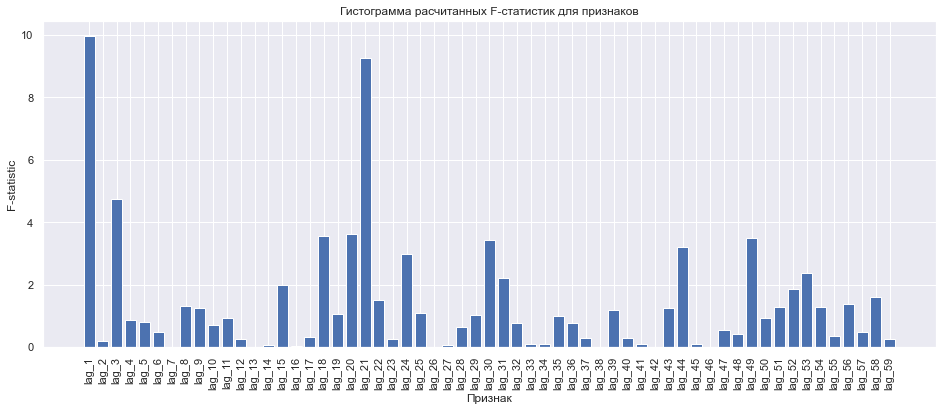

In [45]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.xlabel('Признак')
plt.ylabel('F-statistic')
plt.xticks(list(range(0, X_train.shape[1])), X_train.columns, rotation='vertical')
plt.title('Гистограмма расчитанных F-статистик для признаков')
plt.show()

In [46]:
def get_top_n_features(features, scores, n=10):
    top_n_indexes = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:n]
    return [features[i] for i in top_n_indexes]

In [47]:
def compute_errors_for_regressors(train, test, y_train=y_train, y_test=y_test, degree=1):
    errors = []

    for n in range(1, train.shape[1] + 1):
        top_features = get_top_n_features(train.columns, fs.scores_, n=n)
        poly_lr = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        poly_lr.fit(train[top_features], y_train)
        preds = poly_lr.predict(test[top_features])
        errors.append(mean_absolute_percentage_error(preds, y_test))

    plt.bar([i for i in range(len(errors))], errors)
    plt.xlabel('Количество топ-признаков')
    plt.ylabel('MAPE')
    plt.xticks([i for i in range(len(errors))], rotation='vertical')
    plt.title('MAPE для топ-n регрессоров')
    plt.show()

    return errors

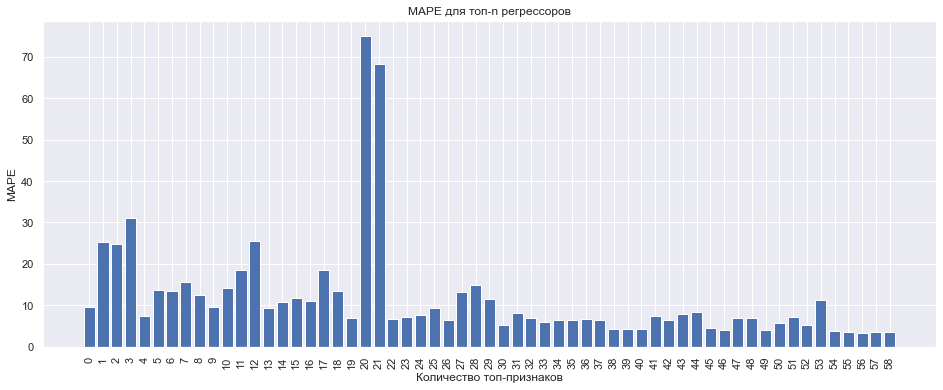

In [48]:
errors = compute_errors_for_regressors(X_train, X_test)

In [49]:
optimal_n = sorted(range(len(errors)), key=lambda x: errors[x])[0]
optimal_n

56

In [50]:
tscv = TimeSeriesSplit(n_splits=5)

def plotModelResults(model, train=X_train, test=X_test, y_train=y_train, y_test=y_test, plot_intervals=False, plot_anomalies=False):
    prediction = model.predict(test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(model, train, y_train,
                             cv=tscv,
                             scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

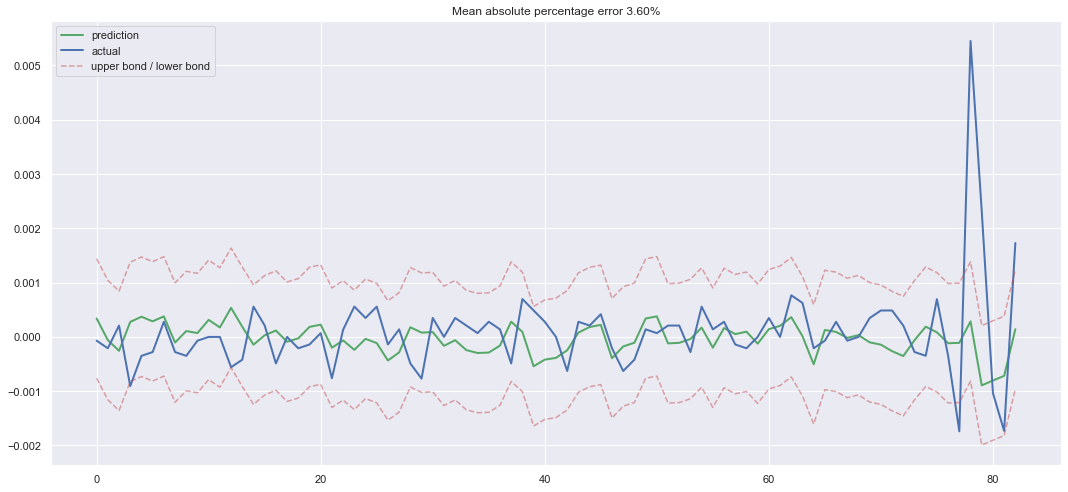

In [51]:
top_features = get_top_n_features(X_train.columns, fs.scores_, n=optimal_n)
lr = LinearRegression()
lr.fit(X_train[top_features], y_train)

plotModelResults(lr, X_train[top_features], X_test[top_features], plot_intervals=True)

In [52]:
mean_absolute_percentage_error(lr.predict(X_test[top_features]), y_test)

3.601861097951797

### Predict to next day

Предположим, что новость вышла 2021-09-21 12:30:00, и необходимо предсказать значения актива на ближайшие 30 минут, определить наилучшее время для захода и профит

In [121]:
aapl_test = intraday[intraday['ticker'] == 'AAPL']
aapl_test = aapl_test[['close', 'time']]
aapl_test = aapl_test[(aapl_test['time'] >= pd.to_datetime('2021-09-20 23:59:00')) & (aapl_test['time'] < pd.to_datetime('2021-09-21 12:30:00'))]

In [122]:
aapl_test['log'] = np.log(aapl_test['close'])
aapl_test['log_diff'] = aapl_test['log'] - aapl_test['log'].shift(1)

for i in range(1, 60):
    aapl_test["lag_{}".format(i)] = aapl_test['log_diff'].shift(i)

aapl_test = aapl_test.dropna()
aapl_test.tail()

,close,time,log,log_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59
265,144.18,2021-09-21 12:25:00,4.971063,0.000624,-0.000208,-0.000278,-0.000277,-0.000139,0.000347,-0.000277,...,0.000416,-0.000139,0.000000,-0.000208,0.000347,0.000000,0.000139,0.000000,-0.000347,0.000069
266,144.13,2021-09-21 12:26:00,4.970716,-0.000347,0.000624,-0.000208,-0.000278,-0.000277,-0.000139,0.000347,...,-0.000277,0.000416,-0.000139,0.000000,-0.000208,0.000347,0.000000,0.000139,0.000000,-0.000347
267,144.07,2021-09-21 12:27:00,4.970299,-0.000416,-0.000347,0.000624,-0.000208,-0.000278,-0.000277,-0.000139,...,-0.000832,-0.000277,0.000416,-0.000139,0.000000,-0.000208,0.000347,0.000000,0.000139,0.000000
268,144.07,2021-09-21 12:28:00,4.970299,0.000000,-0.000416,-0.000347,0.000624,-0.000208,-0.000278,-0.000277,...,0.000139,-0.000832,-0.000277,0.000416,-0.000139,0.000000,-0.000208,0.000347,0.000000,0.000139
269,144.12,2021-09-21 12:29:00,4.970646,0.000347,0.000000,-0.000416,-0.000347,0.000624,-0.000208,-0.000278,...,-0.000208,0.000139,-0.000832,-0.000277,0.000416,-0.000139,0.000000,-0.000208,0.000347,0.000000


Предсказания на 30 минут вперед

In [123]:
times = pd.date_range(start='2021-09-21 12:30:00', periods=30, freq='min')

for t in times:
    last_value = aapl_test.tail(1)[top_features]
    preds = lr.predict(last_value.values.reshape(1, -1))
    new_df = pd.DataFrame(
        {
            'log': aapl_test.tail(1)['log'] + preds,
            'time': t
        }
    )
    new_df['close'] = np.exp(new_df['log'])
    aapl_test = aapl_test.append(new_df)

    aapl_test['log_diff'] = aapl_test['log'] - aapl_test['log'].shift(1)
    for i in range(1, 60):
        time_in["lag_{}".format(i)] = aapl_test['log_diff'].shift(i)

<AxesSubplot:xlabel='time'>

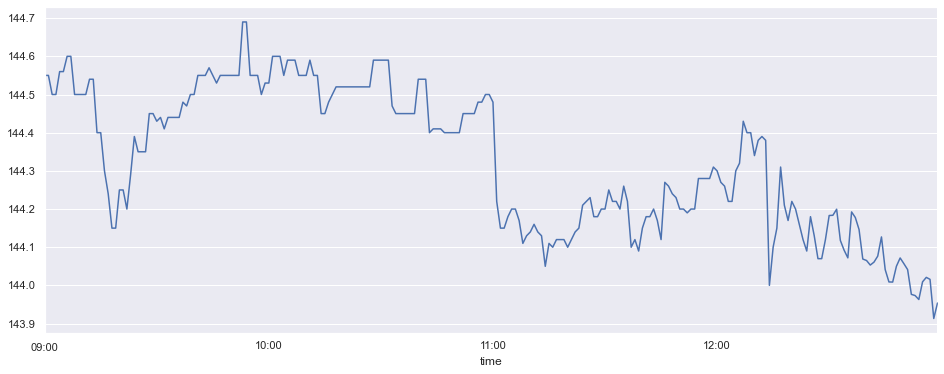

In [129]:
aapl_test.set_index('time')['close'].plot()

In [124]:
def profit(in_money, data, time_news_out, time_in, time_out):
    t1 = time_news_out + pd.Timedelta(time_in, unit='m')
    t1 = t1.floor('Min')
    t_in = data[data["time"] == t1]
    if t_in.empty:
        return 0
    stock = in_money / t_in["close"].values[0]
    t2 = time_news_out + pd.Timedelta(time_out, unit='m')
    t2 = t2.floor('Min')
    t_out = data[data["time"] == t2]
    if t_out.empty:
        return 0
    result = stock * t_out["close"].values[0]
    return (result - in_money) / (in_money) * 100


In [125]:
result = []

for time_in in [i for i in range(30)]:
    for time_out in [j for j in range(time_in, 30)]:
        p = profit(
            in_money=100000,
            data=aapl_test.tail(30),
            time_news_out=pd.to_datetime('2021-09-21 12:30:00'),
            time_in=time_in,
            time_out=time_out
        )
        result.append((time_in, time_out, p))

In [126]:
sorted(result, key=lambda x: x[2], reverse=True)[:5]

[(5, 6, 0.08352129438072735),
 (5, 7, 0.07336062117244001),
 (4, 6, 0.06956258492422057),
 (4, 7, 0.05940332883119118),
 (3, 6, 0.0519252973003604)]